#  Analysis Regression Cross-sectional Equity Template 
**German Hernandez**

This post presents the analysis of a linear regression predictor of the return PRED_N_FORWARD_DAYS latter to be used as combined_factor for the [Cross-sectional Equity Template] (https://www.quantopian.com/algorithms/5d14d0dace2ee337d7289254) included in the examples. 

I use the segments of code  form the great posts [Machine Learning on Quantopian Part 3: Building an Algorithm - Thomas Wiecki](https://www.quantopian.com/posts/machine-learning-on-quantopian-part-3-building-an-algorithm)  and [How to Leverage the Pipeline to Conduct Machine Learning in the IDE –  Jim Obreen](https://www.quantopian.com/posts/how-to-leverage-the-pipeline-to-conduct-machine-learning-in-the-ide) to build the ML(CustomFactor) and the pipeline. 

In [1]:
from collections import OrderedDict
from time import time

import pandas as pd
import numpy as np

from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.pipeline.factors import SimpleMovingAverage

from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.experimental import risk_loading_pipeline

from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data.builtin import USEquityPricing

from quantopian.pipeline.factors import (
    CustomFactor,
    Returns,
)

from zipline.utils.numpy_utils import (
    repeat_first_axis,
    repeat_last_axis,
)

# SKLearn :)
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.preprocessing import Imputer, StandardScaler

from quantopian.research import run_pipeline
from time import time

import matplotlib.pyplot as plt

In [2]:
##################################################
# Globals 
##################################################

# Constraint Parameters
MAX_GROSS_LEVERAGE = 1.0
TOTAL_POSITIONS = 600

# train on returns over N days into the future
PRED_N_FORWARD_DAYS = 5
TRAINING_WINDOW_DAYS = 30
PERCENT = 0.05

universe = QTradableStocksUS()

In [3]:
##################################################################################
#  x_pipeline for inputs x of the regression model
##################################################################################

def x_pipeline():
    
    # The factors we create here are based on fundamentals data and a moving
    # average of sentiment data
    returns = Returns(
        inputs=(USEquityPricing.open,),
        mask=universe, window_length=PRED_N_FORWARD_DAYS + 1,
    )
    value = Fundamentals.ebit.latest / Fundamentals.enterprise_value.latest
    quality = Fundamentals.roe.latest
    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )
        
    returns = returns.winsorize(min_percentile=PERCENT, max_percentile=1.0-PERCENT).zscore()
    value = value.winsorize(min_percentile=PERCENT, max_percentile=1.0-PERCENT).zscore()
    quality = quality.winsorize(min_percentile=PERCENT, max_percentile=1.0-PERCENT).zscore()
    sentiment_score = sentiment_score.winsorize(min_percentile=PERCENT,max_percentile=1.0-PERCENT).zscore()
    
    # Create pipeline
    pipe = Pipeline(
        columns={
            'Returns':returns, 
            'value': value,
            'quality': quality,
            'sentiment_score': sentiment_score,
        },
        screen= universe
    )
    return pipe

In [4]:
###########################################################################################################
# Training inputs x from 2018-11-27 to 2018-12-31, 30 and 7 days before the testing day 2019-01-07 
###########################################################################################################

start = pd.Timestamp("2018-11-27")
end = pd.Timestamp("2018-12-31")
start_timer = time()
x = run_pipeline(x_pipeline(), start_date=start, end_date=end)
x.index.names = ['date', 'security']
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 69.51 secs


In [5]:
x.head()

Returns   quality  \
date                      security                                
2018-11-27 00:00:00+00:00 Equity(2 [ARNC])   0.541368  0.385388   
                          Equity(24 [AAPL]) -2.034985  0.969342   
                          Equity(41 [ARCB]) -0.029310  0.559286   
                          Equity(52 [ABM])   0.024395  0.340777   
                          Equity(53 [ABMD]) -1.250670  0.600070   

                                             sentiment_score     value  
date                      security                                      
2018-11-27 00:00:00+00:00 Equity(2 [ARNC])         -0.577120  0.558896  
                          Equity(24 [AAPL])        -0.507977  0.492773  
                          Equity(41 [ARCB])         2.013294  1.227861  
                          Equity(52 [ABM])         -0.074877  0.421955  
                          Equity(53 [ABMD])         0.500770  0.148643

In [6]:
x.tail()

Returns   quality  \
date                      security                                     
2018-12-31 00:00:00+00:00 Equity(51815 [GLIB_A]) -1.437027  0.594410   
                          Equity(51832 [ZS])      0.732218  0.011669   
                          Equity(51854 [DBX])    -0.571669  0.144841   
                          Equity(51895 [SPOT])   -0.783175  0.404043   
                          Equity(51917 [ZUO])    -0.395066 -0.493985   

                                                  sentiment_score     value  
date                      security                                           
2018-12-31 00:00:00+00:00 Equity(51815 [GLIB_A])              NaN  1.325223  
                          Equity(51832 [ZS])             0.399160  0.041427  
                          Equity(51854 [DBX])           -0.390583  0.054420  
                          Equity(51895 [SPOT])           0.296103       NaN  
                          Equity(51917 [ZUO])           -0.578802 -0.110521

In [7]:
x.reset_index(drop=True, inplace=True)
x.head()

,Returns,quality,sentiment_score,value
0,0.541368,0.385388,-0.577120,0.558896
1,-2.034985,0.969342,-0.507977,0.492773
2,-0.029310,0.559286,2.013294,1.227861
3,0.024395,0.340777,-0.074877,0.421955
4,-1.250670,0.600070,0.500770,0.148643


In [8]:
x.reset_index(drop=True, inplace=True)
x.head()

,Returns,quality,sentiment_score,value
0,0.541368,0.385388,-0.577120,0.558896
1,-2.034985,0.969342,-0.507977,0.492773
2,-0.029310,0.559286,2.013294,1.227861
3,0.024395,0.340777,-0.074877,0.421955
4,-1.250670,0.600070,0.500770,0.148643


In [9]:
x.count

<bound method DataFrame.count of         Returns   quality  sentiment_score     value
0      0.541368  0.385388        -0.577120  0.558896
1     -2.034985  0.969342        -0.507977  0.492773
2     -0.029310  0.559286         2.013294  1.227861
3      0.024395  0.340777        -0.074877  0.421955
4     -1.250670  0.600070         0.500770  0.148643
5     -0.463250  0.311431         1.970797  0.215056
6      0.269666 -0.072429         1.333335 -0.121542
7      0.286198 -3.225739         0.130914  0.058445
8      0.327823  0.349416         0.004323  0.532009
9     -0.576095  0.368526         1.418974 -0.140584
10    -0.987367  0.658944         0.643684  0.214185
11     0.966467  0.433215         0.976935  0.344019
12     0.015298  0.372269        -0.351111  0.545068
13     0.359651  0.221217        -0.310545  0.165396
14    -0.424874  0.385406         0.697804  0.326781
15    -0.762550  0.384989         2.013294  0.519433
16     0.988943  0.417575        -0.864944  0.790608
17     0.8543

In [10]:
x.count()

Returns            49730
quality            49361
sentiment_score    49523
value              44590
dtype: int64

In [11]:
def y_pipeline():
    
    # The factors we create here are based on fundamentals data and a moving
    # average of sentiment data
    return_n_days = Returns(
        inputs=(USEquityPricing.open,),
        mask=universe, window_length=PRED_N_FORWARD_DAYS + 1,
    )   

    # Create pipeline
    pipe = Pipeline(
        columns={
            'y': return_n_days,
        },
        screen= universe
    )
    return pipe

In [12]:
###########################################################################################################
# Training outputs y from 2018-12-04 to testing day 2019-01-07
###########################################################################################################
start = pd.Timestamp("2018-12-04")
end = pd.Timestamp("2019-01-07")
start_timer = time()
y= run_pipeline(y_pipeline(), start_date=start, end_date=end)
y.index.names = ['date', 'security']
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 1.13 secs


In [13]:
y.head()

y
date                      security                   
2018-12-04 00:00:00+00:00 Equity(2 [ARNC])   0.042009
                          Equity(24 [AAPL])  0.058655
                          Equity(41 [ARCB])  0.024060
                          Equity(52 [ABM])   0.050803
                          Equity(53 [ABMD])  0.126808

In [14]:
y.tail()

y
date                      security                      
2019-01-07 00:00:00+00:00 Equity(51832 [ZS])    0.051860
                          Equity(51854 [DBX])   0.005382
                          Equity(51895 [SPOT]) -0.005326
                          Equity(51917 [ZUO])   0.045061
                          Equity(51934 [EAF])   0.038121

In [15]:
y.reset_index(drop=True, inplace=True)
y.head()

,y
0,0.042009
1,0.058655
2,0.024060
3,0.050803
4,0.126808


In [16]:
y.count

<bound method DataFrame.count of               y
0      0.042009
1      0.058655
2      0.024060
3      0.050803
4      0.126808
5      0.080896
6     -0.016678
7      0.096681
8      0.023979
9      0.038919
10     0.137528
11     0.039118
12     0.038995
13    -0.004128
14     0.020354
15     0.036569
16     0.027394
17     0.069225
18     0.035220
19    -0.001367
20     0.016425
21     0.030409
22     0.006471
23    -0.048544
24     0.018945
25     0.057544
26     0.049223
27     0.076750
28     0.126253
29     0.032356
...         ...
47371  0.030653
47372  0.059574
47373 -0.000710
47374  0.024416
47375 -0.029141
47376  0.040263
47377  0.061422
47378  0.018038
47379 -0.031460
47380  0.031988
47381  0.024339
47382  0.091794
47383  0.028986
47384  0.013102
47385  0.081958
47386  0.053650
47387  0.064748
47388  0.046977
47389 -0.006801
47390  0.006154
47391  0.148710
47392  0.042424
47393  0.094841
47394  0.170443
47395  0.069988
47396  0.051860
47397  0.005382
47398 -0.005326
47399  

In [17]:
y.count()

y    47401
dtype: int64

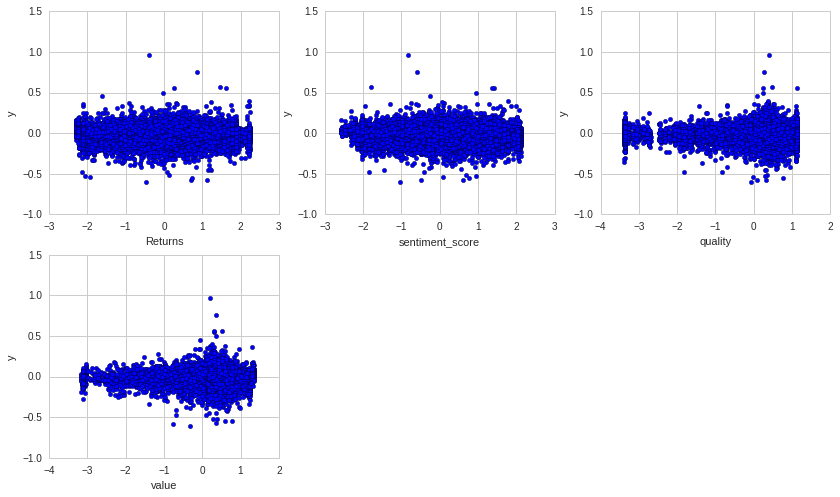

In [18]:
columns = ['Returns', 'sentiment_score', 'quality', 'value']
yy = np.ravel(Imputer(strategy='median',axis=1).fit_transform(y['y']))

for i in range(0,4):
                plt.subplot(2, 3, i+1)
                plt.scatter(np.array(x[columns[i]])[:len(y)],yy) 
                plt.xlabel(columns[i])
                plt.ylabel('y')

In [19]:
#############################################################################################
#  ML(CustomFactor)  and ml_pipeline with regression predictor as combined_factor
#############################################################################################


class ML(CustomFactor):
    """
    """
    train_on_weekday = 1

    def __init__(self, *args, **kwargs):
        CustomFactor.__init__(self, *args, **kwargs)

        self._regressor  = LinearRegression()
        self._trained = False

    def _compute(self, *args, **kwargs):
        ret = CustomFactor._compute(self, *args, **kwargs)
        return ret

    def compute(self, today, assets, out, *inputs): #compute(self, today, assets, out, returns, *inputs):
        # inputs has the Returns n_forward_days+1 and the 3 alpha factors from Cross-sectional Equity Template
        #  inputs[0]: (Returns)
        # [[1, 3, 2], # factor 1 rankings of day t-1 for 3 stocks
        #  [3, 2, 1]] # factor 1 rankings of day t for 3 stocks
        # inputs[1]:
        # [[2, 3, 1], # factor 2 rankings of day t-1 for 3 stocks
        #  [1, 2, 3]] # factor 2 rankings of day t for 3 stocks
        
        
        print('preprocessing starting on: {}'.format(today))
        
        columns = ['Returns', 'sentiment_score', 'quality', 'value']
 
        regressor = self._regressor
            
        inputs = OrderedDict([(columns[i] , pd.DataFrame(inputs[i]).fillna(method='ffill',axis=1).fillna(method='bfill',axis=1)) for i in range(len(inputs))]) # bring in data with some null handling.
            
        print "inputs"
        print inputs
            
        y = inputs['Returns']. shift(-PRED_N_FORWARD_DAYS).dropna(axis=0,how='all').stack(dropna=False)
            
        print "y"
        print len(y)
        print y
        
            
        num_secs = len(inputs['Returns'].columns)
                
        print "num_secs"
        print  num_secs
            
        x = pd.concat([df.stack(dropna=False) for df in inputs.values()], axis=1)
        x.columns = columns
                
        x = Imputer(strategy='median',axis=1).fit_transform(x) # fill nulls.         
        y = np.ravel(Imputer(strategy='median',axis=1).fit_transform(y)) # fill nulls.
        scaler = StandardScaler()
        x = scaler.fit_transform(x) # demean and normalize
        x_t =x[-num_secs:,:]
        x = x[:-num_secs*(PRED_N_FORWARD_DAYS),:]         
        
        if (today.weekday() == self.train_on_weekday) or not self._trained:
            
            print "today.weekday() == self.train_on_weekday",today.weekday() == self.train_on_weekday
            print " not self._trained", not self._trained
            
            print('training model for window starting on: {}'.format(today))
            
            for i in range(0,4):
                plt.subplot(2, 3, i+1)
                plt.scatter(x[:,i],y) 
                plt.xlabel(columns[i])
                plt.ylabel('y')
            
            start = time()
            
            regressor.fit(x, y)
        
            print('training took {} secs'.format(time() - start))
           
            print('score',regressor.score(x, y))
        
        
            self._trained = True
            
        out[:] = regressor.predict(x_t)

def ml_pipeline():
    """
    A function that creates and returns our pipeline.

    We break this piece of logic out into its own function to make it easier to
    test and modify in isolation. In particular, this function can be
    copy/pasted into research and run by itself.

    Returns
    -------
    pipe : Pipeline
        Represents computation we would like to perform on the assets that make
        it through the pipeline screen.
    """
    
    value = Fundamentals.ebit.latest / Fundamentals.enterprise_value.latest
    quality = Fundamentals.roe.latest
    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )
    
    input_columns =  OrderedDict([
        ('value', value),
        ('quality', quality),
        ('sentiment_score', sentiment_score),
    ])
    
    predictor_columns = OrderedDict()
    
    predictor_columns['Returns'] = Returns(
        inputs=(USEquityPricing.open,),
        mask=universe, window_length=PRED_N_FORWARD_DAYS + 1,
    )

    # rank all the factors and put them after returns
    predictor_columns.update({
        k: v.winsorize(min_percentile=PERCENT, max_percentile=1.0-PERCENT).zscore() for k, v in input_columns.items()
    })
    
    print predictor_columns.keys()
    
    # Create our ML pipeline factor. The window_length will control how much
    # lookback the passed in data will have.
    combined_factor = ML(
        inputs=predictor_columns.values(),
        window_length=TRAINING_WINDOW_DAYS,
        mask=universe,
    )
    
    
    # Build Filters representing the top and bottom baskets of stocks by our
    # combined ranking system. We'll use these as our tradeable universe each
    # day.
    longs = combined_factor.top(TOTAL_POSITIONS//2, mask=universe)
    shorts = combined_factor.bottom(TOTAL_POSITIONS//2, mask=universe)

    # The final output of our pipeline should only include
    # the top/bottom 300 stocks by our criteria
    long_short_screen = (longs | shorts)

    # Create pipeline
    pipe = Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts,
            'combined_factor': combined_factor
        },
        screen=long_short_screen
    )
    return pipe

['Returns', 'sentiment_score', 'quality', 'value']


preprocessing starting on: 2019-01-07 00:00:00+00:00
inputs
OrderedDict([('Returns',         0         1         2         3         4         5         6     \
0  -0.006464 -0.069196 -0.014307  0.009766 -0.156192 -0.006773 -0.060560   
1  -0.021068 -0.073079 -0.038961 -0.006585 -0.080048 -0.010699  0.022556   
2   0.013440 -0.071394 -0.010449  0.004670 -0.034452 -0.014362  0.033118   
3   0.010244 -0.085354 -0.009680 -0.007805 -0.052320 -0.024830  0.001335   
4   0.005459 -0.097316 -0.027750 -0.037983 -0.021295 -0.045694  0.023322   
5   0.023524 -0.009194 -0.017571 -0.022244  0.095944 -0.004120  0.147520   
6   0.038539  0.016302  0.028067  0.016241  0.081632  0.044412  0.043750   
7   0.044204  0.030582  0.008241  0.035857  0.114979  0.088166  0.098051   
8   0.042009  0.058655  0.024060  0.050803  0.126808  0.080896  0.096681   
9   0.062192  0.055041  0.021342  0.028202  0.101940  0.080483  0.067715   
10 -0.003423 -0.028122 -0.051322 -0.034619  0.004295  0.006990 -0.035234   
11 

training took 0.00682091712952 secs
('score', 0.017899939464864456)


Time to run pipeline 63.31 secs


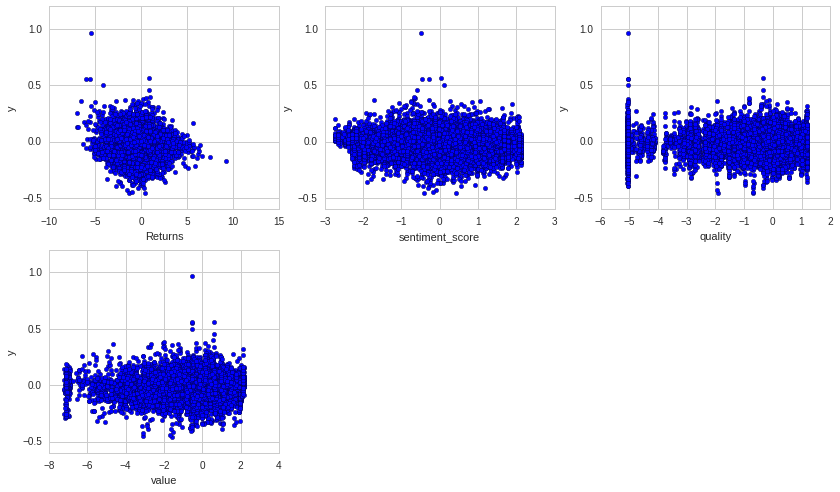

In [20]:

start = pd.Timestamp("2019-01-07")
end = pd.Timestamp("2019-01-07")
start_timer = time()
results = run_pipeline(ml_pipeline(), start_date=start, end_date=end)
results.index.names = ['date', 'security']
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

In [21]:
results.head()

combined_factor  longs shorts
date                      security                                         
2019-01-07 00:00:00+00:00 Equity(2 [ARNC])          -0.039217  False   True
                          Equity(24 [AAPL])         -0.009412   True  False
                          Equity(62 [ABT])          -0.018256   True  False
                          Equity(67 [ADSK])         -0.033167  False   True
                          Equity(114 [ADBE])        -0.019833   True  False

In [22]:
results.tail()

combined_factor  longs  \
date                      security                                         
2019-01-07 00:00:00+00:00 Equity(51725 [FTSI])          -0.041356  False   
                          Equity(51742 [WHD])           -0.032795  False   
                          Equity(51806 [CRON])          -0.046538  False   
                          Equity(51815 [GLIB_A])        -0.032248  False   
                          Equity(51895 [SPOT])          -0.019564   True   

                                                 shorts  
date                      security                       
2019-01-07 00:00:00+00:00 Equity(51725 [FTSI])     True  
                          Equity(51742 [WHD])      True  
                          Equity(51806 [CRON])     True  
                          Equity(51815 [GLIB_A])   True  
                          Equity(51895 [SPOT])    False